In [195]:
import numpy as np
import matplotlib.pyplot as plt
import pde
import os


# Boundary conditions test

In [196]:
class CustomPDE(pde.PDEBase):

    def __init__(self, bc, boundary_mask):
        array_shape = (20, 10, 10)
        # self.x_component_array = np.arange(array_shape[0]).reshape(array_shape[0], 1, 1) * np.ones(array_shape[1:])
        self.bc = bc
        self.boundary_mask = boundary_mask

        # array_shape = (20, 10, 10)
        # x_component_array = np.arange(array_shape[0]).reshape(array_shape[0], 1, 1) * np.ones(array_shape[1:])

        # # Create a new array for the vectors
        # self.vector_array = np.zeros((3, 20, 10, 10))

        # # Fill in the x-component and set y and z components to zero
        # self.vector_array[0] = x_component_array  # x component
        # y and z components remain zero by default

        # This is the correct of ones only in the x-direction
        self.vector_array = np.zeros((3, 20, 10, 10))

        # Set 1 in the x-direction from 9 to 11
        self.vector_array[0, 9:11, :, :] = 1


    def evolution_rate(self, state, t=0):
        """ Custom PDE evolution with modified diffusion rate """
        # laplacian = state.laplace(bc={"value": 0})  # zero Dirichlet boundary condition
        # rate = laplacian.copy()  # Default rate inside the grid
        
        # Reduce the rate of diffusion at grid to a quarter
        # rate.data[self.boundary_mask] *= 0.25
        # state.data[:, np.logical_not(self.boundary_mask)] = 0
        shear_viscosity = 2
        bulk_viscosity = 10
        f_u = state.dot(state.gradient(bc=self.bc)) - shear_viscosity * state.laplace(bc=self.bc) \
                - (bulk_viscosity + shear_viscosity/3) * state.divergence(bc=self.bc).gradient(bc=self.bc) 

        ans = -f_u - 0.000001 * self.vector_array
        ans.data[:, self.boundary_mask] = 0
        return ans


True
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


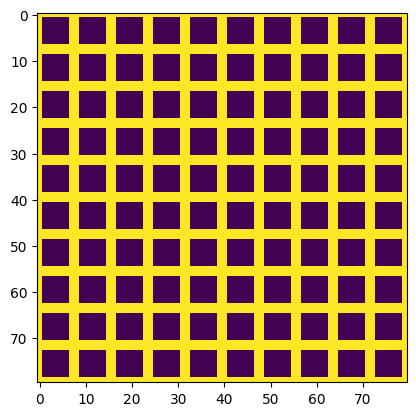

ValueError: operands could not be broadcast together with shapes (3,160,80,80) (3,20,10,10) (3,160,80,80) 

In [197]:
grid = pde.CartesianGrid([[0, 10], [0, 5], [0, 5]], [160, 80, 80], periodic=[False, False, False])
field = pde.VectorField(grid, data=0)

bc_x = ({"value": 0})


# Define the mask for grid lines with thickness of 5 in 3D
x, y, z = grid.cell_coords[..., 0], grid.cell_coords[..., 1], grid.cell_coords[..., 2]
# print(x.shape)
section_size = 10 // 3
# print((4 <= x) & (x <= 6))
y_width = 0.1
y_count = 10
z_width = 0.1
z_count = 10
boundary_mask = (
    ((4 <= x) & (x <= 6)) &
    # (((y % section_size <= 2) | (y % section_size >= section_size - 2)) |
    # (((2 <= y) & (y <= 3)) |
    # ((y%(y_width + y_count) <= y_width) |
    ((y%(5/y_count) >= 5/y_count-y_width/2) | (y%(5/y_count) <= y_width/2) |
    # ((z % section_size <= 2) | (z % section_size >= section_size - 2)))
    # ((2 <= z) & (z <= 3)))
    # (z%(z_width + z_count) <= z_width))
    (z%(5/z_count) >= 5/z_count-z_width/2) | (z%(5/z_count) <= z_width/2))
)
print(boundary_mask.any())
print(boundary_mask[20,:, :])

# Plot the boundary mask on a 2d plot with false = 0 and true = 1
plt.imshow(boundary_mask[80,:, :])
plt.show()



# eq = CustomPDE(bc=[bc_x, bc_x, bc_x])
eq = CustomPDE(bc=[bc_x, bc_x, bc_x], boundary_mask=boundary_mask)

storage = pde.MemoryStorage()
result = eq.solve(field, t_range=40, dt=0.01, tracker=storage.tracker(0.1))

result.to_scalar(scalar='norm').plot_interactive()

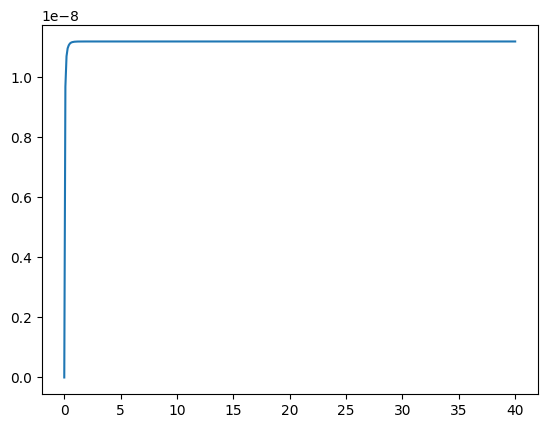

In [64]:
# Cross-section
def get_slice(storage, slice=32):
    # Transform the 3D storage data to 2D slice at depth z
    grid_size = [10, 10]
    grid = pde.UnitGrid(grid_size)  
    
    new_data = []
    for time in range(len(storage)):
        # data=storage[time].data[:,:,slice]
        norm = np.linalg.norm(storage[time].data, axis=0)
        data=norm[slice, :, :]

        new_data.append(data)
    new_data = np.array(new_data)
    field_obj = pde.ScalarField(grid, data=new_data[0])
    res = pde.storage.memory.MemoryStorage(times=list(range(len(storage))), data=new_data, field_obj=field_obj)
    # print("res",res[0])
        
    return res

## Usage

new_storage = get_slice(storage, 5)
# pde.movie(new_storage, filename="output3.mp4", plot_args={}, movie_args={})

# Plot average of slice vs time
plt.plot(np.linspace(0, 40, 401), get_slice(storage, 10).data.mean(axis=(1, 2)))
plt.show()


In [65]:
# grid = pde.CartesianGrid([[0, 10], [0, 5], [0, 5]], [20, 10, 10], periodic=[False, False, False])
# field = pde.VectorField(grid, data=0)
# field.insert((5,5,5), [0.001,0,0])
# field.to_scalar(scalar='norm').plot_interactive()
# eq = CustomPDE(boundary_mask=False)
# result = eq.solve(field, t_range=60, dt=0.1)
# result.to_scalar(scalar='norm').plot_interactive()